In [1]:
# !pip install yfinance
# !pip install treeinterpreter
# !pip install tensorflow
# !pip install flair
# !pip install torch
# !pip install xgboost

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import yfinance as yf
import csv
import re
import os
import sys
import flair
import seaborn as sns

In [3]:
import unicodedata

In [4]:
from sklearn.model_selection import train_test_split
from treeinterpreter import treeinterpreter as ti
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from math import sqrt

## Analysing and cleaning of datasets

In [5]:
dogecoin_stock = pd.read_csv('DOGE-USD.csv')

In [6]:
dogecoin_stock.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-11-09,0.001207,0.001415,0.001181,0.001415,0.001415,6259550.0
1,2017-11-10,0.001421,0.001431,0.001125,0.001163,0.001163,4246520.0
2,2017-11-11,0.001146,0.001257,0.001141,0.001201,0.001201,2231080.0
3,2017-11-12,0.001189,0.001210,0.001002,0.001038,0.001038,3288960.0
4,2017-11-13,0.001046,0.001212,0.001019,0.001211,0.001211,2481270.0


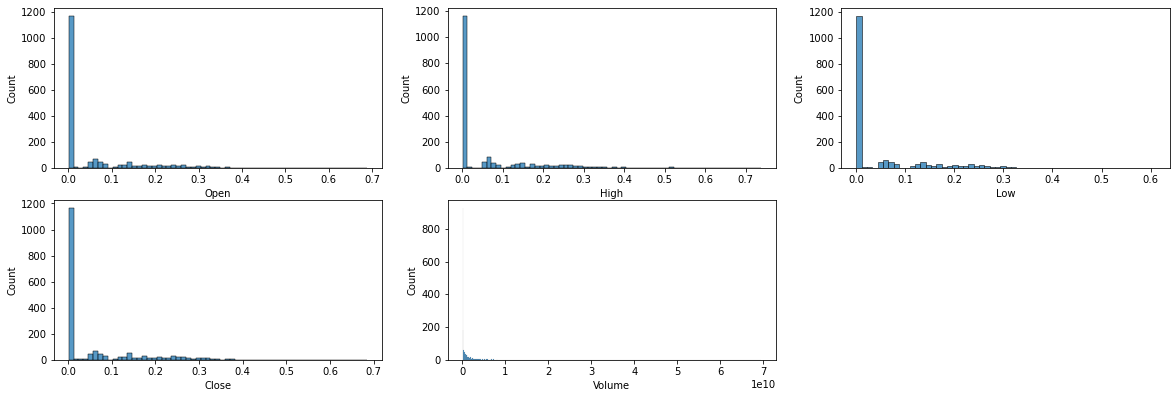

In [7]:
# Code gotten from https://www.geeksforgeeks.org/stock-price-prediction-using-machine-learning-in-python/
# and changed for my purpose

features = ['Open', 'High', 'Low', 'Close', 'Volume']
 
plt.subplots(figsize=(20,10))
 
for i, col in enumerate(features):
    plt.subplot(3,3,i+1)
    sns.histplot(dogecoin_stock[col])
plt.show()

All the columns seem very left skewed

In [8]:
dogecoin_stock_orig = dogecoin_stock.copy()

In [9]:
elon_tweets = pd.read_csv('elonmusktweets.csv')

In [10]:
dogecoin_stock = dogecoin_stock.drop('Adj Close', axis = 1)

In [11]:
dogecoin_stock['target'] = np.where(dogecoin_stock['Close'].shift(-1) > dogecoin_stock['Close'], 1, 0)

In [12]:
dogecoin_stock

,Date,Open,High,Low,Close,Volume,target
0,2017-11-09,0.001207,0.001415,0.001181,0.001415,6259550.0,0
1,2017-11-10,0.001421,0.001431,0.001125,0.001163,4246520.0,1
2,2017-11-11,0.001146,0.001257,0.001141,0.001201,2231080.0,0
3,2017-11-12,0.001189,0.001210,0.001002,0.001038,3288960.0,1
4,2017-11-13,0.001046,0.001212,0.001019,0.001211,2481270.0,0
...,...,...,...,...,...,...,...
1756,2022-08-31,0.061534,0.063333,0.061058,0.061330,309748693.0,1
1757,2022-09-01,0.061336,0.062479,0.060194,0.062372,328765413.0,0
1758,2022-09-02,0.062372,0.062712,0.060947,0.061635,273453013.0,0
1759,2022-09-03,NaN,NaN,NaN,NaN,NaN,0


In [13]:
elon_tweets.head()

,Date Created,Number of Likes,Source of Tweet,Tweets
0,2022-09-12 05:44:11+00:00,1524,Twitter for iPhone,@teslaownersSV @cb_doge @Tesla @mayemusk I gue...
1,2022-09-12 05:43:02+00:00,19631,Twitter for iPhone,@cb_doge @Tesla @mayemusk Still doing same thi...
2,2022-09-12 04:19:57+00:00,9221,Twitter for iPhone,Looks good to roll out to all Tesla owners wit...
3,2022-09-12 03:25:03+00:00,944,Twitter for iPhone,@Tesla__Mania @WholeMarsBlog That is probably ...
4,2022-09-12 01:48:49+00:00,3710,Twitter for iPhone,@WholeMarsBlog Real-world validation &amp; bil...


In [14]:
elon_tweets.shape

(17437, 4)

<AxesSubplot:title={'center':'Source of Tweet'}>

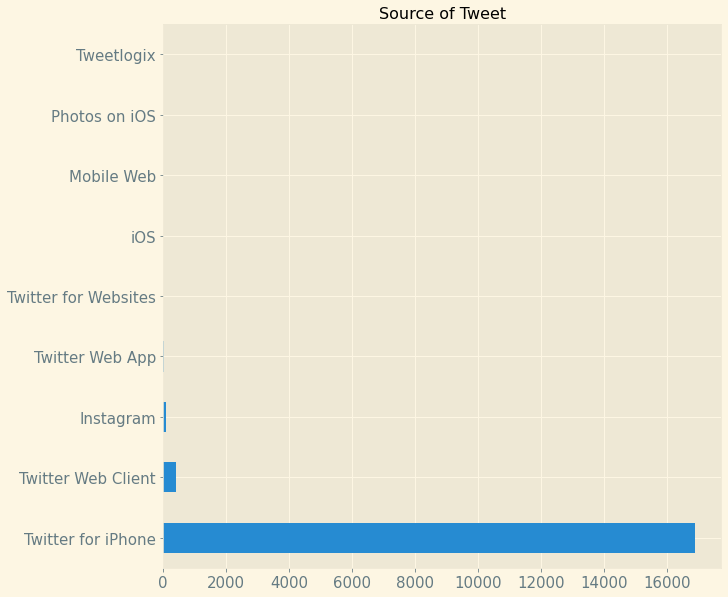

In [15]:
# Source: https://www.kaggle.com/code/tayyarhussain/elon-musk-tweets-dataset-data-analysis

plt.style.use('Solarize_Light2')
elon_tweets["Source of Tweet"].value_counts().plot(kind="barh",figsize=(10,10),title="Source of Tweet",fontsize=15)

<AxesSubplot:xlabel='Number of Likes', ylabel='Count'>

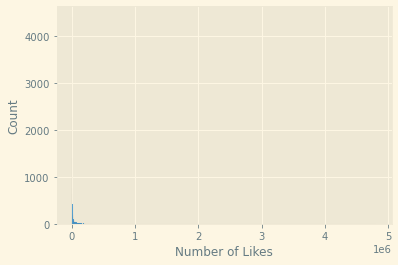

In [16]:
sns.histplot(elon_tweets['Number of Likes'] )

In [17]:
# Flip the columns to start from the earliest date rather than sorted from earliest to oldest.
elon_tweets = elon_tweets[::-1].reset_index(drop = True)

In [18]:
# top 5 rows of the dataset after flipping the dataset.
elon_tweets.head() 

,Date Created,Number of Likes,Source of Tweet,Tweets
0,2010-06-04 18:31:57+00:00,6042,Twitter Web Client,"Please ignore prior tweets, as that was someon..."
1,2011-12-01 09:55:11+00:00,189,Twitter Web Client,Went to Iceland on Sat to ride bumper cars on ...
2,2011-12-01 10:29:04+00:00,75,Twitter Web Client,I made the volume on the Model S http://t.co/w...
3,2011-12-03 08:20:28+00:00,53,Twitter for iPhone,"Great Voltaire quote, arguably better than Twa..."
4,2011-12-03 08:22:07+00:00,51,Twitter for iPhone,That was a total non sequitur btw


In [19]:
# Creating a new df, new_tweets, with the relevant data and resetting the index as the index is not relevant in this case.
elon_tweets = elon_tweets[2926:17364].reset_index(drop = True) 

In [20]:
elon_tweets.head()

,Date Created,Number of Likes,Source of Tweet,Tweets
0,2017-09-19 16:36:39+00:00,1410,Twitter for iPhone,"@JimHeaney Absolutely. Moreover, we expect to ..."
1,2017-09-20 16:25:08+00:00,16071,Twitter for iPhone,@Its_Subhamk Don't give up if the cause is imp...
2,2017-09-24 19:31:24+00:00,19254,Twitter for iPhone,@USATODAYmoney @NathanBomey That's not a lot o...
3,2017-09-25 10:12:44+00:00,5753,Twitter for iPhone,Presentation of @SpaceX Interplanetary Spacesh...
4,2017-09-25 10:15:05+00:00,9857,Twitter for iPhone,Major improvements &amp; some unexpected appli...


In [21]:
elon_tweets.shape

(14438, 4)

In [22]:
pd.options.mode.chained_assignment = None  # default='warn'

In [23]:
elon_tweets['isDogeTweet'] = None

In [24]:
elon_tweets.columns

Index(['Date Created', 'Number of Likes', 'Source of Tweet', 'Tweets',
       'isDogeTweet'],
      dtype='object')

## Filtering out tweets that are related to dogecoin

In [25]:
# Marking tweets that contain Doge/doge/Dogecoin/dogecoin with 1 and 0 if they do not contain the dogecoin or doge word.
elon_tweets["isDogeTweet"][elon_tweets['Tweets'].str.upper().str.contains("DOGECOIN")] = 1
elon_tweets["isDogeTweet"][elon_tweets['Tweets'].str.upper().str.contains("DOGE-USD")] = 1
# elon_tweets["isDogeTweet"][elon_tweets['Tweets'].str.upper().str.contains("DOGE")] = 1

In [26]:
elon_tweets.head()

,Date Created,Number of Likes,Source of Tweet,Tweets,isDogeTweet
0,2017-09-19 16:36:39+00:00,1410,Twitter for iPhone,"@JimHeaney Absolutely. Moreover, we expect to ...",None
1,2017-09-20 16:25:08+00:00,16071,Twitter for iPhone,@Its_Subhamk Don't give up if the cause is imp...,None
2,2017-09-24 19:31:24+00:00,19254,Twitter for iPhone,@USATODAYmoney @NathanBomey That's not a lot o...,None
3,2017-09-25 10:12:44+00:00,5753,Twitter for iPhone,Presentation of @SpaceX Interplanetary Spacesh...,None
4,2017-09-25 10:15:05+00:00,9857,Twitter for iPhone,Major improvements &amp; some unexpected appli...,None


In [27]:
elon_tweets = elon_tweets.dropna()

In [28]:
elon_tweets['isDogeTweet'].sum()

51

In [29]:
elon_tweets.reset_index(inplace = True)

In [30]:
elon_tweets.shape

(51, 6)

## Checking the source of the tweets

<AxesSubplot:title={'center':'Source of Tweet'}>

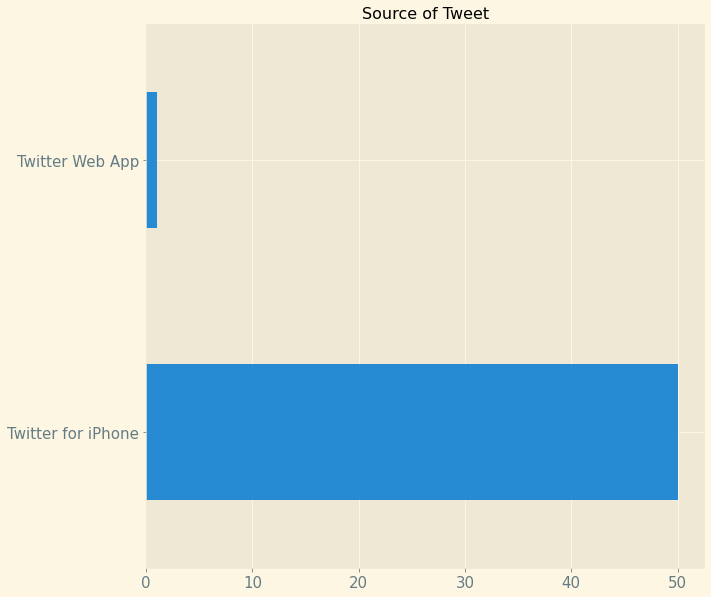

In [31]:
# Source: https://www.kaggle.com/code/tayyarhussain/elon-musk-tweets-dataset-data-analysis

plt.style.use('Solarize_Light2')
elon_tweets["Source of Tweet"].value_counts().plot(kind="barh",figsize=(10,10),title="Source of Tweet",fontsize=15)

In [32]:
elon_tweets = elon_tweets.drop('index', axis = 1)
elon_tweets = elon_tweets.drop('Source of Tweet', axis = 1)
elon_tweets = elon_tweets.drop('isDogeTweet', axis = 1)

In [33]:
elon_tweets.to_csv('doge_elon.csv')

## Using regex to remove symbols and usernames from the dataset

In [34]:
# Source: https://towardsdatascience.com/sentiment-analysis-for-stock-price-prediction-in-python-bed40c65d178

whitespace = re.compile(r"\s+")
web_address = re.compile(r"(?i)http(s):\/\/[a-z0-9.~_\-\/]+")
doge = re.compile(r"(?i)@Dogecoin(?=\b)")
user = re.compile(r"(?i)@[a-z0-9_]+")

# we then use the sub method to replace anything matching
for i in range(elon_tweets.shape[0]):
    tweet = elon_tweets['Tweets'][i]
    tweet = whitespace.sub(' ', tweet)
    tweet = web_address.sub('', tweet)
    tweet = doge.sub('Dogecoin', tweet)
    tweet = user.sub('', tweet)
    elon_tweets['Tweets'][i] = tweet

In [35]:
# replacing empty tweets after regex with nan so I can drop them
elon_tweets['Tweets'].replace(' ', np.nan, inplace=True)

In [36]:
# Dropping tweets with nan
elon_tweets.dropna(inplace=True)

In [37]:
# Resetting indices
elon_tweets.reset_index(inplace = True)

In [38]:
# Removing old index column
elon_tweets = elon_tweets.drop('index', axis = 1)

In [39]:
# Renaming Date created column so I can merge with the dogecoin dataset
elon_tweets = elon_tweets.rename(columns={'Date Created':'Date'})

In [40]:
elon_tweets.to_csv('doge_elon_cleaned_tweets.csv')

In [41]:
sentiment_model = flair.models.TextClassifier.load('en-sentiment')

2022-11-28 14:37:07,838 loading file C:\Users\bjark\.flair\models\sentiment-en-mix-distillbert_4.pt


In [42]:
elon_tweets['Date'] = pd.to_datetime(elon_tweets['Date']).dt.date

In [43]:
elon_tweets.head(20)

,Date,Number of Likes,Tweets
0,2019-04-02,11986,Dogecoin might be my fav cryptocurrency. It’s...
1,2019-04-02,14875,Dogecoin Uh oh
2,2019-04-02,132692,Dogecoin rulz
3,2019-04-02,19183,Dogecoin value may vary
4,2020-04-25,2275,Dogecoin Mode
5,2021-02-04,523602,Dogecoin is the people’s crypto
6,2021-02-07,57190,🤣🤣
7,2021-02-07,7170,🤣🤣
8,2021-02-10,517771,"Bought some Dogecoin for lil X, so he can be a..."
9,2021-02-14,311321,If major Dogecoin holders sell most of their c...


## Fetching tweets that are from the same day

In [44]:
columns=['Date', 'Number of Likes', 'Tweets']
data = pd.DataFrame(columns=columns)
df2 = pd.read_csv('doge_elon_cleaned_tweets.csv')
df2['Date'] = pd.to_datetime(df2['Date']).dt.date
df2 = df2.drop('Unnamed: 0', axis = 1)
# df2
data['Date'] = pd.to_datetime(data['Date']).dt.date

indx=0
get_tweet=""
n_likes = 0
#get tweets day wise
for i in range(0,len(df2)-1):
    get_date=df2.Date.iloc[i]
    next_date=df2.Date.iloc[i+1]
    if(str(get_date)==str(next_date)):
        get_tweet = get_tweet + df2.Tweets.iloc[i]+" "
        n_likes = n_likes + df2['Number of Likes'].iloc[i]
    if(str(get_date)!=str(next_date)):
        data.at[indx,'Date'] = get_date
        data.at[indx,'Tweets'] = get_tweet
        data.at[indx, 'Number of Likes'] = n_likes
        indx+=1
        get_tweet=" "
        n_likes = 0
        

In [45]:
data.Tweets.replace(" ", np.nan, inplace=True)
data = data.dropna()

In [46]:
data = data.reset_index(drop=True)

In [47]:
data

,Date,Number of Likes,Tweets
0,2019-04-02,159553,Dogecoin might be my fav cryptocurrency. It’s...
1,2021-02-07,57190,🤣🤣
2,2021-02-20,52733,Dogecoin I just set up some little Doge minin...
3,2021-05-20,10275,Es wurde mir in deutschland gegeben
4,2021-05-24,184713,"If you’d like to help develop Doge, please su..."
5,2021-05-25,47845,"Doge has dogs &amp; memes, whereas the othe..."
6,2021-06-25,6289,#gravitas
7,2021-10-24,13559,"Neither Jared, nor me, nor anyone I know ha..."
8,2021-11-25,5888,🔥🔥
9,2022-05-03,104512,I was going full Looney Tunes haha


In [48]:
elon_tweets = elon_tweets.reset_index(drop=True)

## Merging tweets and likes that are from the same day

In [49]:
for i in range(0, len(elon_tweets)):
    for j in range(0, len(data)):
        if(elon_tweets.Date.iloc[i] == data.Date.iloc[j]):
            elon_tweets.Tweets.iloc[i] = data.Tweets.iloc[j]
            elon_tweets['Number of Likes'].iloc[i] = data['Number of Likes'].iloc[j]   
            

In [50]:
elon_tweets

,Date,Number of Likes,Tweets
0,2019-04-02,159553,Dogecoin might be my fav cryptocurrency. It’s...
1,2019-04-02,159553,Dogecoin might be my fav cryptocurrency. It’s...
2,2019-04-02,159553,Dogecoin might be my fav cryptocurrency. It’s...
3,2019-04-02,159553,Dogecoin might be my fav cryptocurrency. It’s...
4,2020-04-25,2275,Dogecoin Mode
5,2021-02-04,523602,Dogecoin is the people’s crypto
6,2021-02-07,57190,🤣🤣
7,2021-02-07,57190,🤣🤣
8,2021-02-10,517771,"Bought some Dogecoin for lil X, so he can be a..."
9,2021-02-14,311321,If major Dogecoin holders sell most of their c...


In [51]:
elon_tweets = elon_tweets.drop_duplicates()

In [52]:
elon_tweets.reset_index(drop=True)

,Date,Number of Likes,Tweets
0,2019-04-02,159553,Dogecoin might be my fav cryptocurrency. It’s...
1,2020-04-25,2275,Dogecoin Mode
2,2021-02-04,523602,Dogecoin is the people’s crypto
3,2021-02-07,57190,🤣🤣
4,2021-02-10,517771,"Bought some Dogecoin for lil X, so he can be a..."
5,2021-02-14,311321,If major Dogecoin holders sell most of their c...
6,2021-02-20,52733,Dogecoin I just set up some little Doge minin...
7,2021-03-02,14953,2022: Dogecoin is dumb
8,2021-03-13,72472,Origin of Doge Day Afternoon: The ancient Roma...
9,2021-03-25,7517,You raise a good point haha


In [53]:
elon_tweets

,Date,Number of Likes,Tweets
0,2019-04-02,159553,Dogecoin might be my fav cryptocurrency. It’s...
4,2020-04-25,2275,Dogecoin Mode
5,2021-02-04,523602,Dogecoin is the people’s crypto
6,2021-02-07,57190,🤣🤣
8,2021-02-10,517771,"Bought some Dogecoin for lil X, so he can be a..."
9,2021-02-14,311321,If major Dogecoin holders sell most of their c...
10,2021-02-20,52733,Dogecoin I just set up some little Doge minin...
12,2021-03-02,14953,2022: Dogecoin is dumb
13,2021-03-13,72472,Origin of Doge Day Afternoon: The ancient Roma...
14,2021-03-25,7517,You raise a good point haha


## Tweets with emojis are not considered by the sentiment analyser. Setting them as text instead

In [54]:
elon_tweets['Tweets'][6] = "Lol lol"
elon_tweets['Tweets'][23] = "Lol lol"
elon_tweets['Tweets'][36] = "That's lit"
elon_tweets['Tweets'][47] = "Thumbs up"
elon_tweets['Tweets'][50] = "Lol"

In [55]:
elon_tweets = elon_tweets.reset_index(drop=True)

In [56]:
elon_tweets

,Date,Number of Likes,Tweets
0,2019-04-02,159553,Dogecoin might be my fav cryptocurrency. It’s...
1,2020-04-25,2275,Dogecoin Mode
2,2021-02-04,523602,Dogecoin is the people’s crypto
3,2021-02-07,57190,Lol lol
4,2021-02-10,517771,"Bought some Dogecoin for lil X, so he can be a..."
5,2021-02-14,311321,If major Dogecoin holders sell most of their c...
6,2021-02-20,52733,Dogecoin I just set up some little Doge minin...
7,2021-03-02,14953,2022: Dogecoin is dumb
8,2021-03-13,72472,Origin of Doge Day Afternoon: The ancient Roma...
9,2021-03-25,7517,You raise a good point haha


In [57]:
probability = []
sentiments = []

for tweet in elon_tweets['Tweets'].to_list():
    # make prediction
    sentence = flair.data.Sentence(tweet)
    sentiment_model.predict(sentence)
    # extract sentiment prediction
    probability.append(sentence.labels[0].score)  # numerical score 0-1
    sentiments.append(sentence.labels[0].value)
    
elon_tweets['Probability'] = probability
elon_tweets['Sentiment'] = sentiments

In [58]:
elon_tweets.head(40)

,Date,Number of Likes,Tweets,Probability,Sentiment
0,2019-04-02,159553,Dogecoin might be my fav cryptocurrency. It’s...,0.985082,POSITIVE
1,2020-04-25,2275,Dogecoin Mode,0.990528,POSITIVE
2,2021-02-04,523602,Dogecoin is the people’s crypto,0.575867,NEGATIVE
3,2021-02-07,57190,Lol lol,0.929430,POSITIVE
4,2021-02-10,517771,"Bought some Dogecoin for lil X, so he can be a...",0.990182,POSITIVE
5,2021-02-14,311321,If major Dogecoin holders sell most of their c...,0.956478,NEGATIVE
6,2021-02-20,52733,Dogecoin I just set up some little Doge minin...,0.997757,POSITIVE
7,2021-03-02,14953,2022: Dogecoin is dumb,0.999970,NEGATIVE
8,2021-03-13,72472,Origin of Doge Day Afternoon: The ancient Roma...,0.895169,POSITIVE
9,2021-03-25,7517,You raise a good point haha,0.960197,POSITIVE


In [59]:
elon_tweets.to_csv('elon_tweets_sentiment.csv')

In [60]:
elon_tweets.shape

(35, 5)

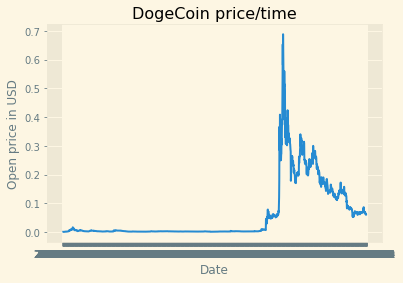

In [61]:
x = dogecoin_stock['Date']
y = dogecoin_stock['Open']
plt.title('DogeCoin price/time')
plt.xlabel('Date')
plt.ylabel('Open price in USD')

plt.plot(x,y) # Plotting the open price vs time.

In [62]:
elon_tweets['Date'].max()

datetime.date(2022, 8, 18)

In [63]:
elon_tweets['Date'].min()


datetime.date(2019, 4, 2)

In [64]:
dogecoin_stock.loc['2019-04-02': '2022-08-28']

,Date,Open,High,Low,Close,Volume,target
202,2018-05-30,0.003447,0.003506,0.003323,0.003354,7463910.0,1


In [65]:
dogecoin_stock[509:510]

,Date,Open,High,Low,Close,Volume,target
509,2019-04-02,0.002459,0.002863,0.002394,0.002795,60298362.0,1


In [66]:
dogecoin_stock.shape

(1761, 7)

In [67]:
dogecoin_stock[1753:1754]

,Date,Open,High,Low,Close,Volume,target
1753,2022-08-28,0.063558,0.064268,0.061786,0.061786,295086067.0,1


In [68]:
dogecoin_stock = dogecoin_stock[509:1755].reset_index(drop = True) 

In [69]:
dogecoin_stock

,Date,Open,High,Low,Close,Volume,target
0,2019-04-02,0.002459,0.002863,0.002394,0.002795,60298362.0,1
1,2019-04-03,0.002777,0.003656,0.002771,0.003164,89863287.0,1
2,2019-04-04,0.003158,0.004096,0.003134,0.003697,164634741.0,0
3,2019-04-05,0.003679,0.003755,0.003409,0.003590,63331136.0,0
4,2019-04-06,0.003594,0.003594,0.003415,0.003439,46343810.0,0
...,...,...,...,...,...,...,...
1241,2022-08-25,0.067991,0.071579,0.067957,0.069094,469798193.0,0
1242,2022-08-26,0.069082,0.069296,0.063254,0.063572,620512451.0,1
1243,2022-08-27,0.063571,0.064065,0.062607,0.063587,380887727.0,0
1244,2022-08-28,0.063558,0.064268,0.061786,0.061786,295086067.0,1


In [70]:
# No tweet for dogecoin for that day so I can just drop that row.
dogecoin_stock = dogecoin_stock.dropna()

In [71]:
# Changing the date column's datatype to datetime
dogecoin_stock['Date'] = pd.to_datetime(dogecoin_stock['Date']).dt.date

In [72]:
#Merging the elon_tweets dataset with the  dogecoin_stock dataset
merged_df = pd.merge(dogecoin_stock, elon_tweets, how='right', left_on='Date', right_on='Date')

In [73]:
merged_df

,Date,Open,High,Low,Close,Volume,target,Number of Likes,Tweets,Probability,Sentiment
0,2019-04-02,0.002459,0.002863,0.002394,0.002795,6.029836e+07,1,159553,Dogecoin might be my fav cryptocurrency. It’s...,0.985082,POSITIVE
1,2020-04-25,0.002102,0.002146,0.002087,0.002142,2.298104e+08,1,2275,Dogecoin Mode,0.990528,POSITIVE
2,2021-02-04,0.037226,0.057869,0.035945,0.053289,1.304084e+10,0,523602,Dogecoin is the people’s crypto,0.575867,NEGATIVE
3,2021-02-07,0.057502,0.084357,0.054239,0.078782,1.426102e+10,1,57190,Lol lol,0.929430,POSITIVE
4,2021-02-10,0.070111,0.081091,0.068525,0.072896,6.785088e+09,0,517771,"Bought some Dogecoin for lil X, so he can be a...",0.990182,POSITIVE
5,2021-02-14,0.066448,0.066448,0.056723,0.062537,3.984668e+09,0,311321,If major Dogecoin holders sell most of their c...,0.956478,NEGATIVE
6,2021-02-20,0.055132,0.060286,0.051628,0.054384,3.175469e+09,1,52733,Dogecoin I just set up some little Doge minin...,0.997757,POSITIVE
7,2021-03-02,0.050596,0.052382,0.049299,0.050262,1.346282e+09,1,14953,2022: Dogecoin is dumb,0.999970,NEGATIVE
8,2021-03-13,0.055353,0.062432,0.054756,0.062432,1.869833e+09,0,72472,Origin of Doge Day Afternoon: The ancient Roma...,0.895169,POSITIVE
9,2021-03-25,0.051699,0.052407,0.049697,0.051448,1.084214e+09,1,7517,You raise a good point haha,0.960197,POSITIVE


In [74]:
merged_df.shape

(35, 11)

In [75]:
merged_df.to_csv('merged_df_sentiment.csv')

In [76]:
# Making a Probs column that has the value of the probability column, negative value for negative sentiment and vice versa
merged_df['Probs'] = None
for i in  range(0, len(merged_df)):
    if merged_df['Sentiment'][i] == 'POSITIVE':
        merged_df['Probs'][i] = merged_df['Probability'][i] 
    else:
        merged_df['Probs'][i] = -merged_df['Probability'][i]

In [77]:
merged_df.head()

,Date,Open,High,Low,Close,Volume,target,Number of Likes,Tweets,Probability,Sentiment,Probs
0,2019-04-02,0.002459,0.002863,0.002394,0.002795,6.029836e+07,1,159553,Dogecoin might be my fav cryptocurrency. It’s...,0.985082,POSITIVE,0.985082
1,2020-04-25,0.002102,0.002146,0.002087,0.002142,2.298104e+08,1,2275,Dogecoin Mode,0.990528,POSITIVE,0.990528
2,2021-02-04,0.037226,0.057869,0.035945,0.053289,1.304084e+10,0,523602,Dogecoin is the people’s crypto,0.575867,NEGATIVE,-0.575867
3,2021-02-07,0.057502,0.084357,0.054239,0.078782,1.426102e+10,1,57190,Lol lol,0.929430,POSITIVE,0.92943
4,2021-02-10,0.070111,0.081091,0.068525,0.072896,6.785088e+09,0,517771,"Bought some Dogecoin for lil X, so he can be a...",0.990182,POSITIVE,0.990182


## Dropping probability and sentiment to reduce clutter in the dataframe

In [78]:
# These are not used further as the information stored in them is now in the Probs column.
merged_df = merged_df.drop('Sentiment', axis = 1)
merged_df = merged_df.drop('Probability', axis = 1)

In [79]:
merged_df.nunique()

Date               35
Open               35
High               35
Low                35
Close              35
Volume             35
target              2
Number of Likes    35
Tweets             34
Probs              34
dtype: int64

In [80]:
merged_df

,Date,Open,High,Low,Close,Volume,target,Number of Likes,Tweets,Probs
0,2019-04-02,0.002459,0.002863,0.002394,0.002795,6.029836e+07,1,159553,Dogecoin might be my fav cryptocurrency. It’s...,0.985082
1,2020-04-25,0.002102,0.002146,0.002087,0.002142,2.298104e+08,1,2275,Dogecoin Mode,0.990528
2,2021-02-04,0.037226,0.057869,0.035945,0.053289,1.304084e+10,0,523602,Dogecoin is the people’s crypto,-0.575867
3,2021-02-07,0.057502,0.084357,0.054239,0.078782,1.426102e+10,1,57190,Lol lol,0.92943
4,2021-02-10,0.070111,0.081091,0.068525,0.072896,6.785088e+09,0,517771,"Bought some Dogecoin for lil X, so he can be a...",0.990182
5,2021-02-14,0.066448,0.066448,0.056723,0.062537,3.984668e+09,0,311321,If major Dogecoin holders sell most of their c...,-0.956478
6,2021-02-20,0.055132,0.060286,0.051628,0.054384,3.175469e+09,1,52733,Dogecoin I just set up some little Doge minin...,0.997757
7,2021-03-02,0.050596,0.052382,0.049299,0.050262,1.346282e+09,1,14953,2022: Dogecoin is dumb,-0.99997
8,2021-03-13,0.055353,0.062432,0.054756,0.062432,1.869833e+09,0,72472,Origin of Doge Day Afternoon: The ancient Roma...,0.895169
9,2021-03-25,0.051699,0.052407,0.049697,0.051448,1.084214e+09,1,7517,You raise a good point haha,0.960197


## Correlation matrix

In [81]:
merged_df.dtypes

Date                object
Open               float64
High               float64
Low                float64
Close              float64
Volume             float64
target               int32
Number of Likes      int64
Tweets              object
Probs               object
dtype: object

In [82]:
# Coercing Probs to be of type float64 instead of object.
merged_df['Probs'] = merged_df['Probs'].astype('float64')

In [83]:
merged_df.corr()

,Open,High,Low,Close,Volume,target,Number of Likes,Probs
Open,1.000000,0.987159,0.997173,0.985348,0.154062,-0.080533,-0.290555,-0.207879
High,0.987159,1.000000,0.985121,0.997758,0.268166,-0.092921,-0.265476,-0.212197
Low,0.997173,0.985121,1.000000,0.986327,0.144986,-0.077348,-0.285100,-0.198134
Close,0.985348,0.997758,0.986327,1.000000,0.258649,-0.106314,-0.265938,-0.223698
Volume,0.154062,0.268166,0.144986,0.258649,1.000000,-0.045497,0.218167,-0.290848
target,-0.080533,-0.092921,-0.077348,-0.106314,-0.045497,1.000000,-0.240397,0.229649
Number of Likes,-0.290555,-0.265476,-0.285100,-0.265938,0.218167,-0.240397,1.000000,-0.143402
Probs,-0.207879,-0.212197,-0.198134,-0.223698,-0.290848,0.229649,-0.143402,1.000000


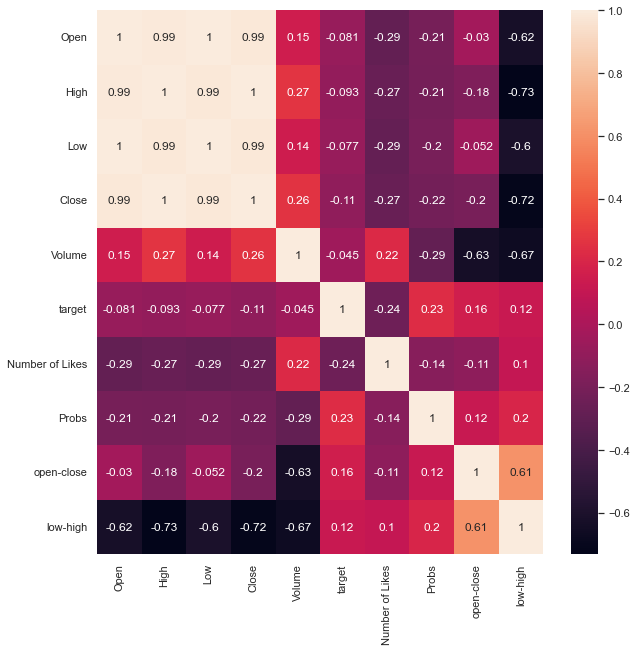

In [133]:
corr_matrix = merged_df.corr()
sns.heatmap(corr_matrix, annot=True)

plt.show()

## Scaling the sentiment probability to try to see if it fits the stock data in any way

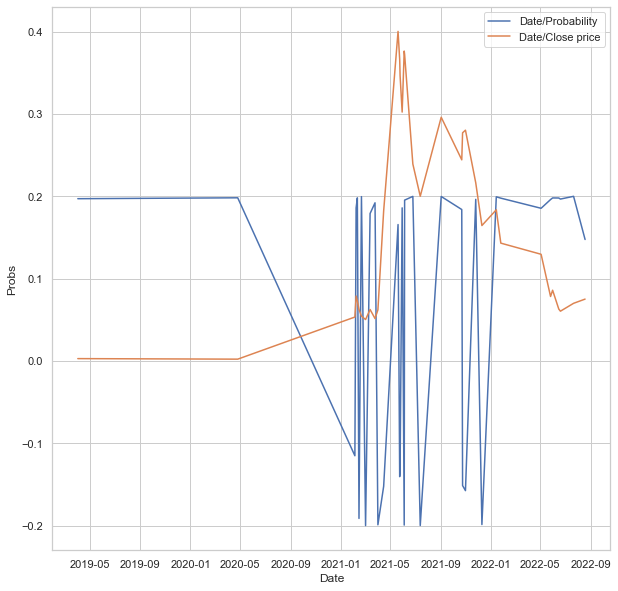

In [85]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(10, 10)})
# plot the sentiment data
sns.set(style='whitegrid')
# sns.scatterplot(x=merged_df['Date'], y=merged_df['Probs'])
sns.lineplot(x=merged_df['Date'], y=merged_df['Probs'] * 0.2, label='Date/Probability')
# and the dogecoin stock price
sns.lineplot(x=merged_df['Date'], y=merged_df['Close'], label = 'Date/Close price')
plt.legend()


In [86]:
merged_df.head()

,Date,Open,High,Low,Close,Volume,target,Number of Likes,Tweets,Probs
0,2019-04-02,0.002459,0.002863,0.002394,0.002795,6.029836e+07,1,159553,Dogecoin might be my fav cryptocurrency. It’s...,0.985082
1,2020-04-25,0.002102,0.002146,0.002087,0.002142,2.298104e+08,1,2275,Dogecoin Mode,0.990528
2,2021-02-04,0.037226,0.057869,0.035945,0.053289,1.304084e+10,0,523602,Dogecoin is the people’s crypto,-0.575867
3,2021-02-07,0.057502,0.084357,0.054239,0.078782,1.426102e+10,1,57190,Lol lol,0.929430
4,2021-02-10,0.070111,0.081091,0.068525,0.072896,6.785088e+09,0,517771,"Bought some Dogecoin for lil X, so he can be a...",0.990182


In [87]:
merged_df

,Date,Open,High,Low,Close,Volume,target,Number of Likes,Tweets,Probs
0,2019-04-02,0.002459,0.002863,0.002394,0.002795,6.029836e+07,1,159553,Dogecoin might be my fav cryptocurrency. It’s...,0.985082
1,2020-04-25,0.002102,0.002146,0.002087,0.002142,2.298104e+08,1,2275,Dogecoin Mode,0.990528
2,2021-02-04,0.037226,0.057869,0.035945,0.053289,1.304084e+10,0,523602,Dogecoin is the people’s crypto,-0.575867
3,2021-02-07,0.057502,0.084357,0.054239,0.078782,1.426102e+10,1,57190,Lol lol,0.929430
4,2021-02-10,0.070111,0.081091,0.068525,0.072896,6.785088e+09,0,517771,"Bought some Dogecoin for lil X, so he can be a...",0.990182
5,2021-02-14,0.066448,0.066448,0.056723,0.062537,3.984668e+09,0,311321,If major Dogecoin holders sell most of their c...,-0.956478
6,2021-02-20,0.055132,0.060286,0.051628,0.054384,3.175469e+09,1,52733,Dogecoin I just set up some little Doge minin...,0.997757
7,2021-03-02,0.050596,0.052382,0.049299,0.050262,1.346282e+09,1,14953,2022: Dogecoin is dumb,-0.999970
8,2021-03-13,0.055353,0.062432,0.054756,0.062432,1.869833e+09,0,72472,Origin of Doge Day Afternoon: The ancient Roma...,0.895169
9,2021-03-25,0.051699,0.052407,0.049697,0.051448,1.084214e+09,1,7517,You raise a good point haha,0.960197


In [88]:
merged_df.nunique()

Date               35
Open               35
High               35
Low                35
Close              35
Volume             35
target              2
Number of Likes    35
Tweets             34
Probs              34
dtype: int64

In [89]:
# Making sure I don't have to deal with any more nan values.
merged_df.isna().sum()

Date               0
Open               0
High               0
Low                0
Close              0
Volume             0
target             0
Number of Likes    0
Tweets             0
Probs              0
dtype: int64

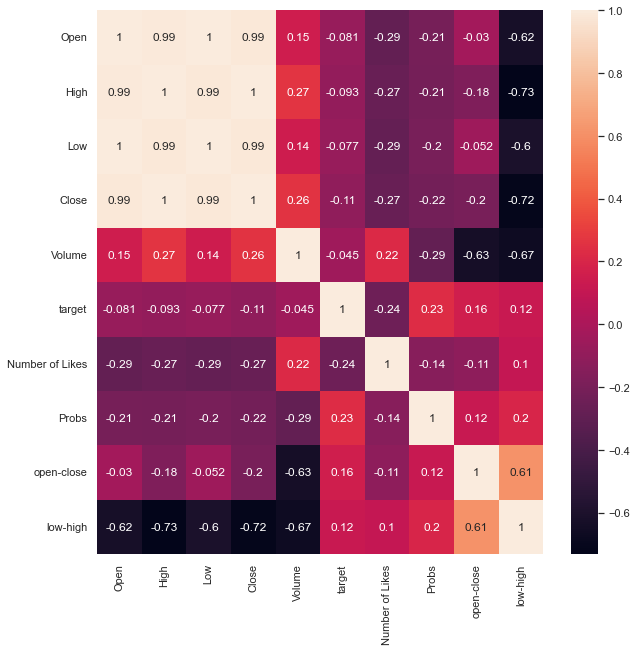

In [143]:
corr_matrix = merged_df.corr()
sns.heatmap(corr_matrix, annot=True)

plt.show()

In [91]:
merged_df['open-close']  = merged_df['Open'] - merged_df['Close']
merged_df['low-high']  = merged_df['Low'] - merged_df['High']
# merged_df['target'] = np.where(merged_df['Close'].shift(-1) > merged_df['Close'], 1, 0)

C:\Users\bjark\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\bjark\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\bjark\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

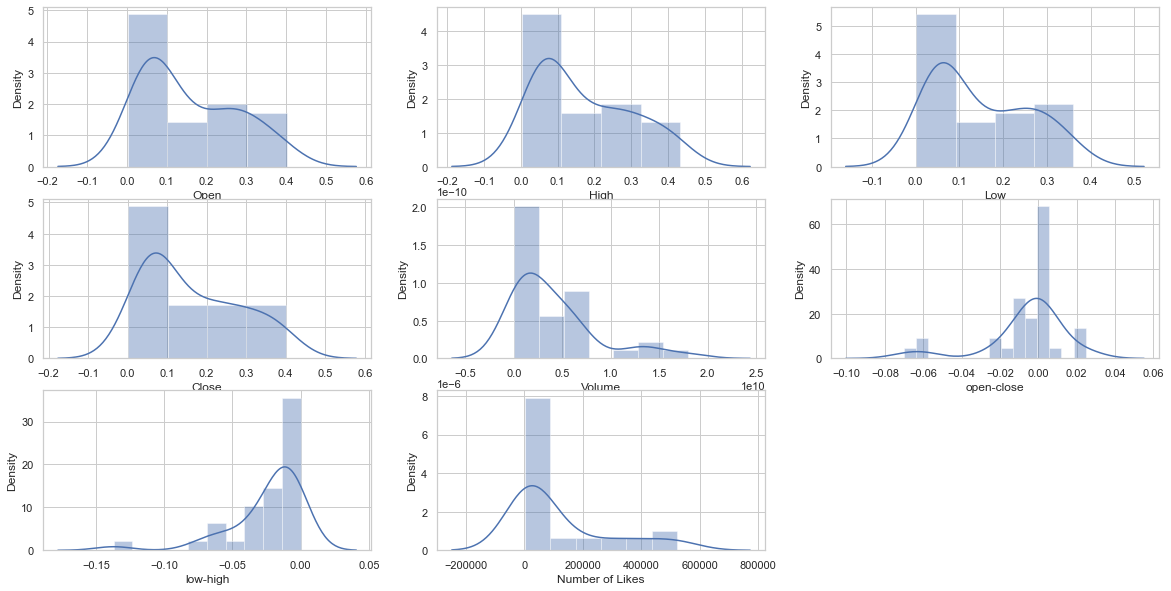

In [92]:
# Code gotten from https://www.geeksforgeeks.org/stock-price-prediction-using-machine-learning-in-python/
# and changed for my purpose

features = ['Open', 'High', 'Low', 'Close', 'Volume', 'open-close', 'low-high', 'Number of Likes']
 
plt.subplots(figsize=(20,10))
 
for i, col in enumerate(features):
    plt.subplot(3,3,i+1)
    sns.distplot(merged_df[col])
plt.show()

Most columns seem left skewed except open-close and low-high

## Correlation matrix of features close, open-close and probs

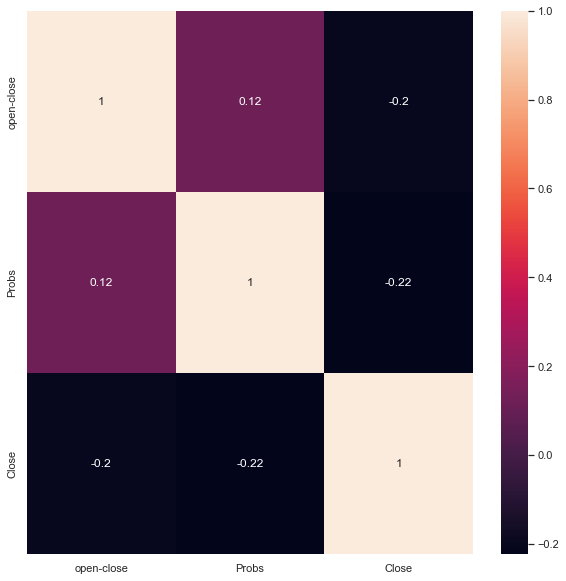

In [93]:
# Corre
dy= merged_df['Probs']
dx= merged_df['open-close']
dz= merged_df['Close']
tempdf = pd.merge(dx, dy, left_index=True, right_index=True)
corrdf = pd.merge(tempdf, dz, left_index=True, right_index=True )
corr = corrdf.corr()

sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns, annot=True)
plt.show()


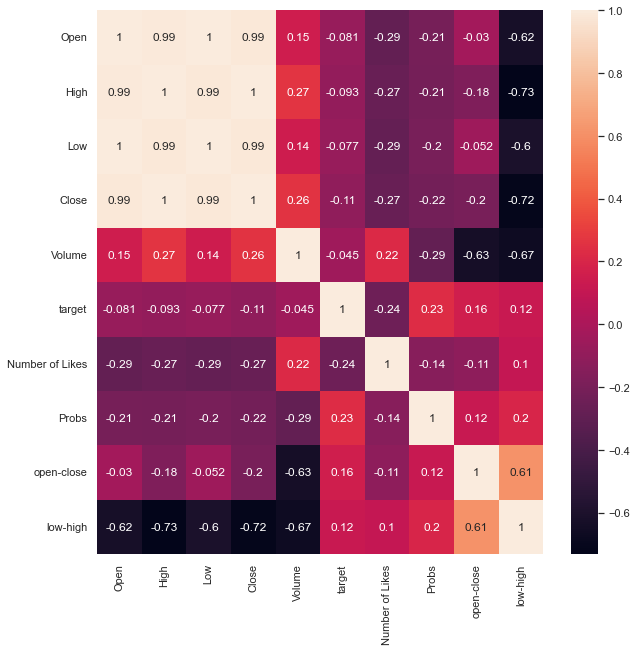

In [94]:
corr_matrix = merged_df.corr()
sns.heatmap(corr_matrix, annot=True)

plt.show()

## Distribution of target

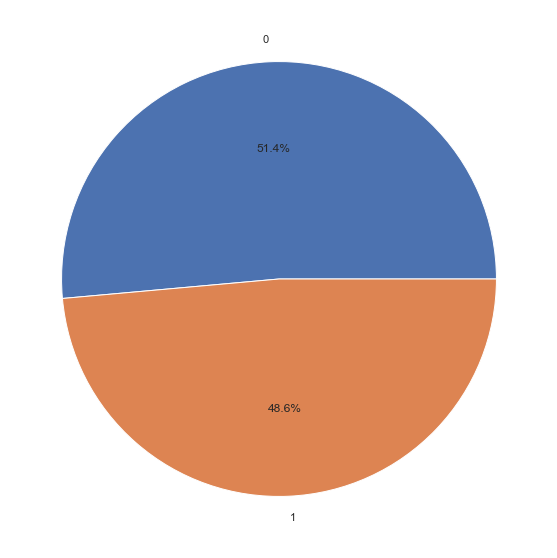

In [95]:
# Plotting the distribution of values (0,1) in target column
plt.pie(merged_df['target'].value_counts().values,
        labels=[0, 1], autopct='%1.1f%%')
plt.show()

^Pretty well balanced

In [96]:
merged_df.head()

,Date,Open,High,Low,Close,Volume,target,Number of Likes,Tweets,Probs,open-close,low-high
0,2019-04-02,0.002459,0.002863,0.002394,0.002795,6.029836e+07,1,159553,Dogecoin might be my fav cryptocurrency. It’s...,0.985082,-0.000336,-0.000469
1,2020-04-25,0.002102,0.002146,0.002087,0.002142,2.298104e+08,1,2275,Dogecoin Mode,0.990528,-0.000040,-0.000059
2,2021-02-04,0.037226,0.057869,0.035945,0.053289,1.304084e+10,0,523602,Dogecoin is the people’s crypto,-0.575867,-0.016063,-0.021924
3,2021-02-07,0.057502,0.084357,0.054239,0.078782,1.426102e+10,1,57190,Lol lol,0.929430,-0.021280,-0.030118
4,2021-02-10,0.070111,0.081091,0.068525,0.072896,6.785088e+09,0,517771,"Bought some Dogecoin for lil X, so he can be a...",0.990182,-0.002785,-0.012566


In [97]:
merged_df = merged_df.dropna()

In [98]:
merged_df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'target',
       'Number of Likes', 'Tweets', 'Probs', 'open-close', 'low-high'],
      dtype='object')

## ML models

In [99]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, precision_score, recall_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold

## Trying to visualize the SVM hyperplanes with 3 features.

In [100]:
# Source: https://stackoverflow.com/questions/51495819/how-to-plot-svm-decision-boundary-in-sklearn-python
# https://towardsdatascience.com/support-vector-machines-svm-clearly-explained-a-python-tutorial-for-classification-problems-29c539f3ad8

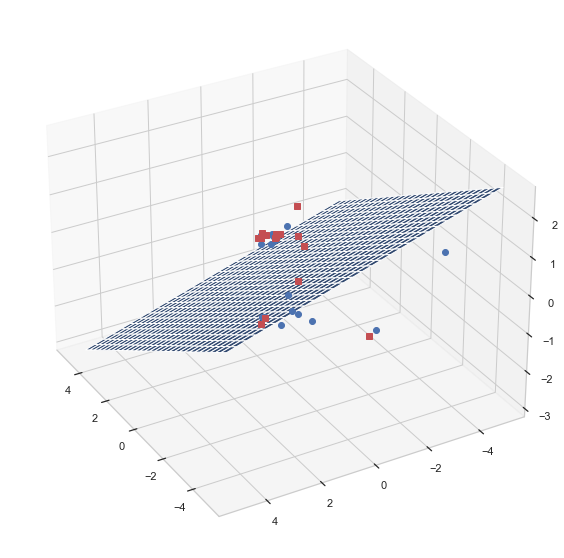

In [138]:
features = merged_df[['open-close', 'low-high', 'Probs']]
target = merged_df['target']
scaler = StandardScaler() 
features = scaler.fit_transform(features)

X = features  # Using 3 features, 3D graph
Y = target

#make it binary classification problem
X = X[np.logical_or(Y==0,Y==1)]
Y = Y[np.logical_or(Y==0,Y==1)]

model = svm.SVC(kernel='linear')
clf = model.fit(X, Y)

# The equation of the separating plane is given by all x so that np.dot(svc.coef_[0], x) + b = 0.
# Solve for w3 (z)
z = lambda x,y: (-clf.intercept_[0]-clf.coef_[0][0]*x -clf.coef_[0][1]*y) / clf.coef_[0][2]

tmp = np.linspace(-5,5,30)
x,y = np.meshgrid(tmp,tmp)

fig = plt.figure()
ax  = fig.add_subplot(111, projection='3d')
ax.plot3D(X[Y==0,0], X[Y==0,1], X[Y==0,2],'ob')
ax.plot3D(X[Y==1,0], X[Y==1,1], X[Y==1,2],'sr')
ax.plot_surface(x, y, z(x,y))
ax.view_init(30, 150)
plt.show()

## Number of likes, close and probs as features  >>>>> Winner

In [102]:
# Source: https://www.geeksforgeeks.org/stock-price-prediction-using-machine-learning-in-python/
# Changed to fit my models, features, added kfold and crossvalidation on all models along with fscore, recall- and precision score.
features = merged_df[['Number of Likes', 'Close', 'Probs']]
target = merged_df['target']
 
scaler = StandardScaler()
features = scaler.fit_transform(features)
 
X_train, X_valid, Y_train, Y_valid = train_test_split(
    features, target, test_size=0.3, random_state=2022)
print(X_train.shape, X_valid.shape)

(24, 3) (11, 3)


'Number of Likes', 'Close', 'Probs' as features
LogisticRegression() : 
Training Accuracy(ROC_AUC_SCORE) :  0.6180555555555556
Validation Accuracy(ROC_AUC_SCORE) :  0.5666666666666667
Mean cross-validation score: 0.42
K-fold CV average score: 0.47
confusion matrix output:


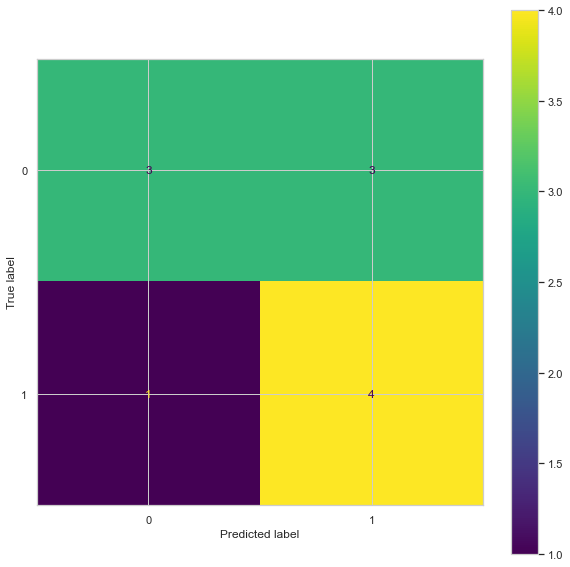

F-Score: 0.6666666666666666
Precision score: 0.5714285714285714
Recall score: 0.8

------------

'Number of Likes', 'Close', 'Probs' as features
SVC(kernel='poly', probability=True) : 
Training Accuracy(ROC_AUC_SCORE) :  0.21527777777777776
Validation Accuracy(ROC_AUC_SCORE) :  0.3666666666666667
Mean cross-validation score: 0.46
K-fold CV average score: 0.47
confusion matrix output:


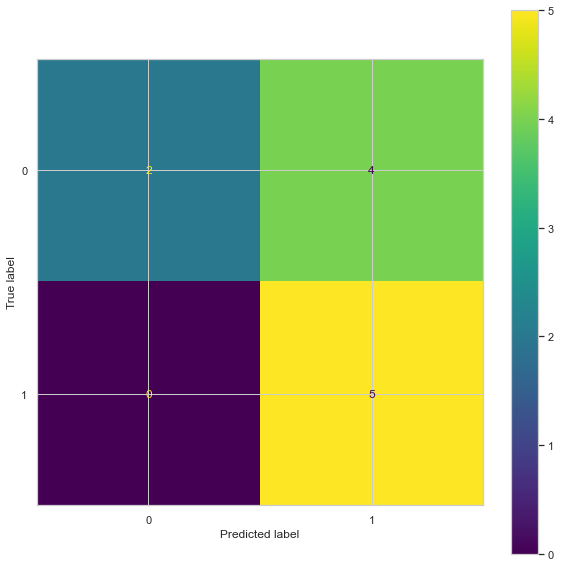

F-Score: 0.7142857142857143
Precision score: 0.5555555555555556
Recall score: 1.0

------------

'Number of Likes', 'Close', 'Probs' as features
XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, ...) : 
Training Accuracy(ROC_AUC_SCORE) :  1.0
Validation Accuracy(ROC_AUC_SCORE) :  0.7000000000000001
Mean cross-validation score: 0.67
K-fold 

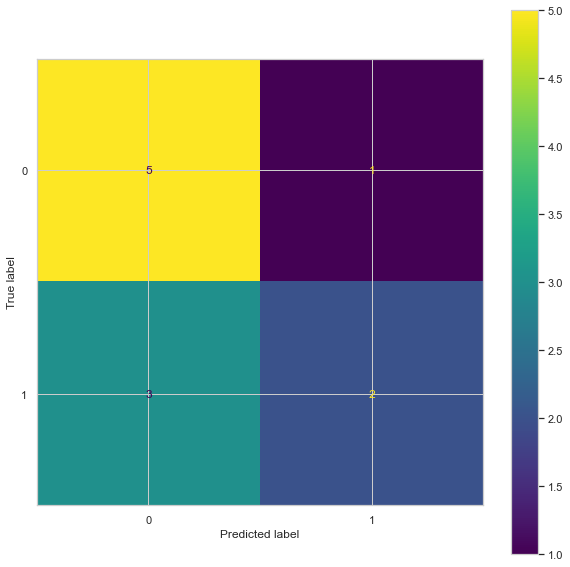

F-Score: 0.5
Precision score: 0.6666666666666666
Recall score: 0.4

------------



In [103]:
models = [LogisticRegression(), SVC(
    kernel='poly', probability=True), XGBClassifier()]


for i in range(3):
    print("'Number of Likes', 'Close', 'Probs' as features")
    models[i].fit(X_train, Y_train)

    print(f'{models[i]} : ')
    print('Training Accuracy(ROC_AUC_SCORE) : ', metrics.roc_auc_score(
        Y_train, models[i].predict_proba(X_train)[:,1]))
    print('Validation Accuracy(ROC_AUC_SCORE) : ', metrics.roc_auc_score(
        Y_valid, models[i].predict_proba(X_valid)[:,1]))
    
# --------------------------
    
    scores = cross_val_score(models[i], X_train, Y_train, cv=5)
    print("Mean cross-validation score: %.2f" % scores.mean())
    kfold = KFold(n_splits=10, shuffle=True)
    kf_cv_scores = cross_val_score(models[i], X_train, Y_train, cv=kfold )
    print("K-fold CV average score: %.2f" % kf_cv_scores.mean())

    ypred = models[i].predict(X_valid)
    cm = confusion_matrix(Y_valid,ypred)
    print('confusion matrix output:')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=clf.classes_) 
    disp.plot()
    plt.show()
    fscore = f1_score(Y_valid, ypred)
    print("F-Score:",fscore)
    precisionscore = precision_score(Y_valid, ypred)
    print("Precision score:", precisionscore)
    recallscore = recall_score(Y_valid, ypred)
    print("Recall score:", recallscore)
    print()
    print("------------")
    print()
    
# --------------------------

## open-close, low-high, probs as features

In [104]:
# Source: https://www.geeksforgeeks.org/stock-price-prediction-using-machine-learning-in-python/
# Changed to fit my models, features, added kfold and crossvalidation on all models along with fscore, recall- and precision score.
features = merged_df[['open-close', 'low-high', 'Probs']]
target = merged_df['target']
 
scaler = StandardScaler()
features = scaler.fit_transform(features)
 
X_train, X_valid, Y_train, Y_valid = train_test_split(
    features, target, test_size=0.3, random_state=2022)
print(X_train.shape, X_valid.shape)


(24, 3) (11, 3)


'open-close', 'low-high', 'Probs' as features
LogisticRegression() : 
Training Accuracy(ROC_AUC_SCORE) :  0.6458333333333334
Validation Accuracy(ROC_AUC_SCORE) :  0.4666666666666667
Mean cross-validation score: 0.42
K-fold CV average score: 0.43
confusion matrix output:


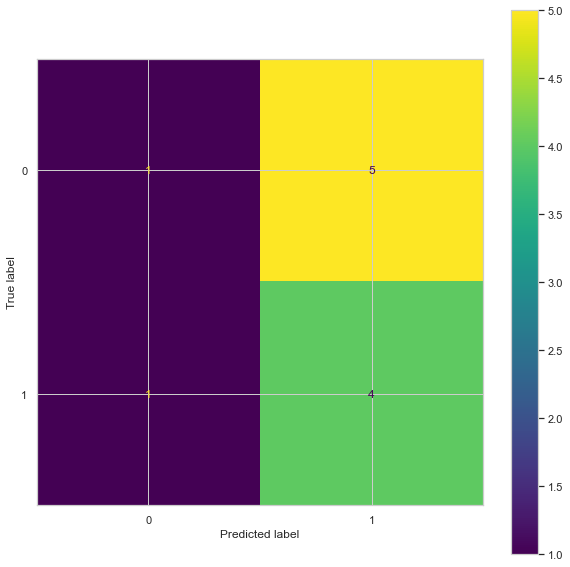

F-Score: 0.5714285714285714
Precision score: 0.4444444444444444
Recall score: 0.8

------------

'open-close', 'low-high', 'Probs' as features
SVC(kernel='poly', probability=True) : 
Training Accuracy(ROC_AUC_SCORE) :  0.2569444444444444
Validation Accuracy(ROC_AUC_SCORE) :  0.5333333333333333
Mean cross-validation score: 0.38
K-fold CV average score: 0.25
confusion matrix output:


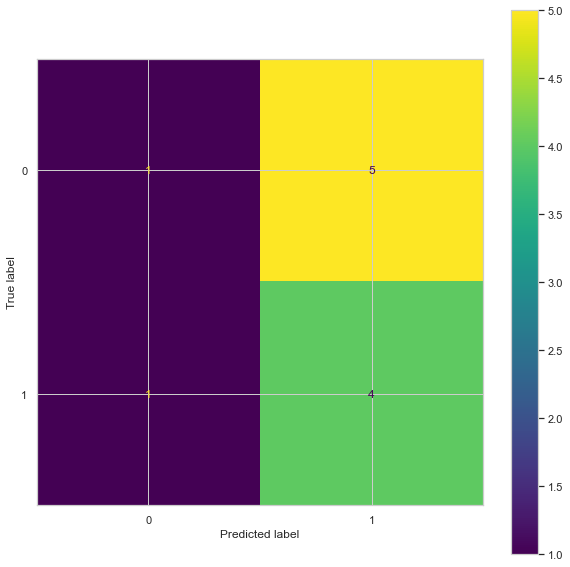

F-Score: 0.5714285714285714
Precision score: 0.4444444444444444
Recall score: 0.8

------------

'open-close', 'low-high', 'Probs' as features
XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, ...) : 
Training Accuracy(ROC_AUC_SCORE) :  1.0
Validation Accuracy(ROC_AUC_SCORE) :  0.7
Mean cross-validation score: 0.33
K-fold CV average score:

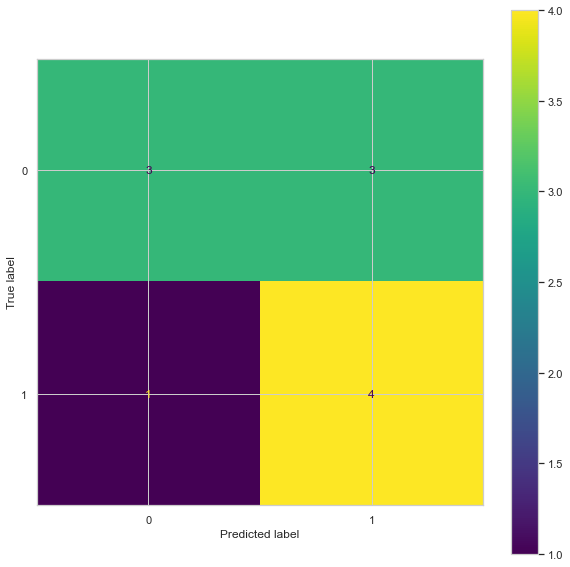

F-Score: 0.6666666666666666
Precision score: 0.5714285714285714
Recall score: 0.8

------------



In [105]:
models = [LogisticRegression(), SVC(
    kernel='poly', probability=True), XGBClassifier()]


for i in range(3):
    print("'open-close', 'low-high', 'Probs' as features") 
    models[i].fit(X_train, Y_train)

    print(f'{models[i]} : ') 
    print('Training Accuracy(ROC_AUC_SCORE) : ', metrics.roc_auc_score(
        Y_train, models[i].predict_proba(X_train)[:,1]))
    print('Validation Accuracy(ROC_AUC_SCORE) : ', metrics.roc_auc_score(
        Y_valid, models[i].predict_proba(X_valid)[:,1]))
    
# --------------------------
    
    scores = cross_val_score(models[i], X_train, Y_train, cv=5)
    print("Mean cross-validation score: %.2f" % scores.mean())
    kfold = KFold(n_splits=10, shuffle=True)
    kf_cv_scores = cross_val_score(models[i], X_train, Y_train, cv=kfold )
    print("K-fold CV average score: %.2f" % kf_cv_scores.mean())

    ypred = models[i].predict(X_valid)
    
    cm = confusion_matrix(Y_valid,ypred)
    print('confusion matrix output:')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=clf.classes_) 
    disp.plot()
    plt.show()
    fscore = f1_score(Y_valid, ypred)
    print("F-Score:",fscore)
    precisionscore = precision_score(Y_valid, ypred)
    print("Precision score:", precisionscore)
    recallscore = recall_score(Y_valid, ypred)
    print("Recall score:", recallscore)
    print()
    print("------------")
    print()
# --------------------------

## Feature importance for XGBoost Classifier with features; 'open-close', 'low-high', 'Probs'

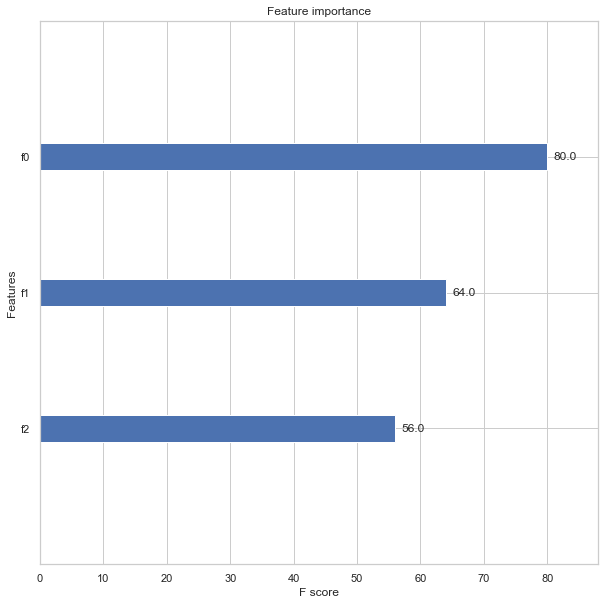

<Figure size 1152x864 with 0 Axes>

In [106]:
xgb_clf = XGBClassifier()
xgb.plot_importance(xgb_clf.fit(X_train, Y_train))
plt.figure(figsize = (16, 12))
plt.show()

## 'open-close', 'low-high', 'Number of Likes', 'Probs', 'Volume' as features -> Overfitted

In [107]:
# Source: https://www.geeksforgeeks.org/stock-price-prediction-using-machine-learning-in-python/
# Changed to fit my models, features, added kfold and crossvalidation on all models

features = merged_df[['open-close', 'low-high', 'Number of Likes', 'Probs', 'Volume']]
target = merged_df['target']
 
scaler = StandardScaler()
features = scaler.fit_transform(features)
 
X_train, X_valid, Y_train, Y_valid = train_test_split(
    features, target, test_size=0.3, random_state=2022)
print(X_train.shape, X_valid.shape)

(24, 5) (11, 5)


'open-close', 'low-high', 'Number of Likes', 'Probs', 'Volume' as features
LogisticRegression() : 
Training Accuracy :  0.7222222222222222
Validation Accuracy :  0.6

Mean cross-validation score: 0.46
K-fold CV average score: 0.40
confusion matrix output:


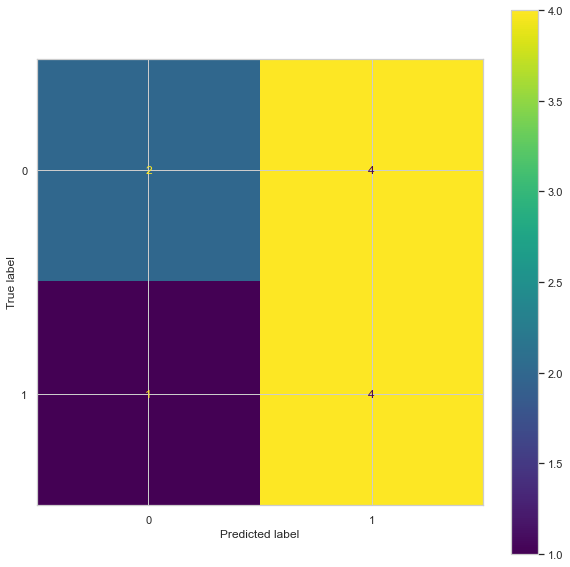

F-Score: 0.6153846153846154
Precision score: 0.5
Recall score: 0.8

------------

'open-close', 'low-high', 'Number of Likes', 'Probs', 'Volume' as features
SVC(kernel='poly', probability=True) : 
Training Accuracy :  0.25
Validation Accuracy :  0.5

Mean cross-validation score: 0.33
K-fold CV average score: 0.20
confusion matrix output:


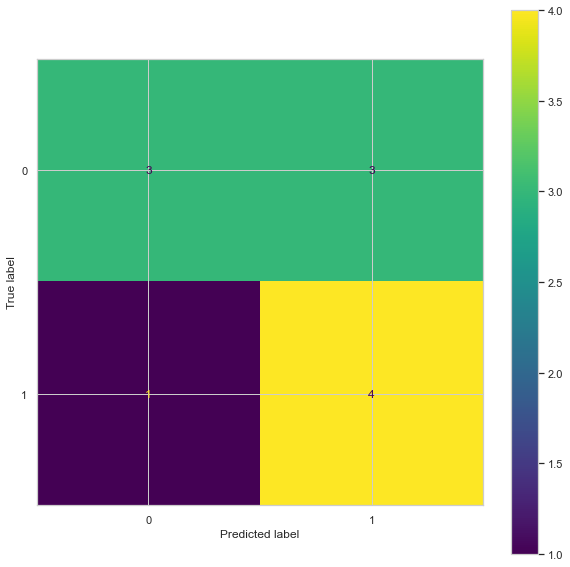

F-Score: 0.6666666666666666
Precision score: 0.5714285714285714
Recall score: 0.8

------------

'open-close', 'low-high', 'Number of Likes', 'Probs', 'Volume' as features
XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, ...) : 
Training Accuracy :  1.0
Validation Accuracy :  0.4

Mean cross-validation score: 0.50
K-fold CV average score:

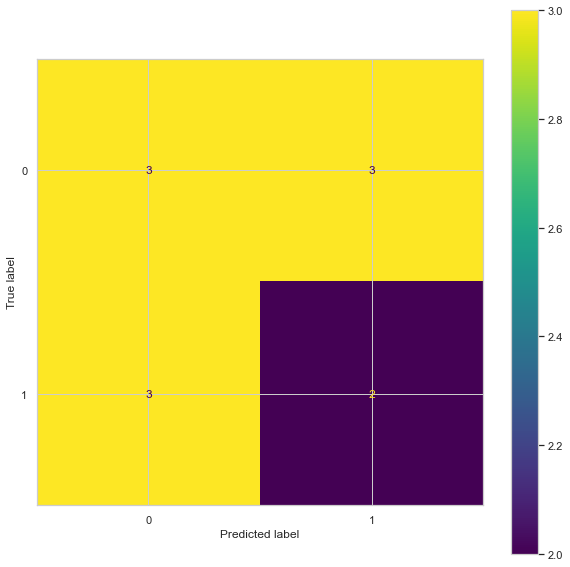

F-Score: 0.4000000000000001
Precision score: 0.4
Recall score: 0.4

------------



In [108]:
models = [LogisticRegression(), SVC(
    kernel='poly', probability=True), XGBClassifier()]


for i in range(3):
    print("'open-close', 'low-high', 'Number of Likes', 'Probs', 'Volume' as features")
    models[i].fit(X_train, Y_train)

    print(f'{models[i]} : ')
    print('Training Accuracy : ', metrics.roc_auc_score(
        Y_train, models[i].predict_proba(X_train)[:,1]))
    print('Validation Accuracy : ', metrics.roc_auc_score(
        Y_valid, models[i].predict_proba(X_valid)[:,1]))
    print()
    
# --------------------------
    
    scores = cross_val_score(models[i], X_train, Y_train, cv=3)
    print("Mean cross-validation score: %.2f" % scores.mean())
    kfold = KFold(n_splits=10, shuffle=True)
    kf_cv_scores = cross_val_score(models[i], X_train, Y_train, cv=kfold )
    print("K-fold CV average score: %.2f" % kf_cv_scores.mean())

    ypred = models[i].predict(X_valid)
    cm = confusion_matrix(Y_valid,ypred)
    print('confusion matrix output:')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=clf.classes_) 
    disp.plot()
    plt.show()
    fscore = f1_score(Y_valid, ypred)
    print("F-Score:",fscore)
    precisionscore = precision_score(Y_valid, ypred)
    print("Precision score:", precisionscore)
    recallscore = recall_score(Y_valid, ypred)
    print("Recall score:", recallscore)
    print()
    print("------------")
    print()
# --------------------------

## open-close, low-high, Number of Likes as features

In [141]:
# Source: https://www.geeksforgeeks.org/stock-price-prediction-using-machine-learning-in-python/
# Changed to fit my models, features, added kfold and crossvalidation on all models along with fscore, recall- and precision score.

features = merged_df[['open-close', 'low-high', 'Number of Likes']]
target = merged_df['target']
 
scaler = StandardScaler()
features = scaler.fit_transform(features)
 
X_train, X_valid, Y_train, Y_valid = train_test_split(
    features, target, test_size=0.3, random_state=2022)
print(X_train.shape, X_valid.shape)

(24, 3) (11, 3)


'open-close', 'low-high', 'Number of Likes' as features
LogisticRegression() : 
Training Accuracy :  0.5347222222222222
Validation Accuracy :  0.43333333333333335

Mean cross-validation score: 0.33
K-fold CV average score: 0.28
Confusion matrix output:


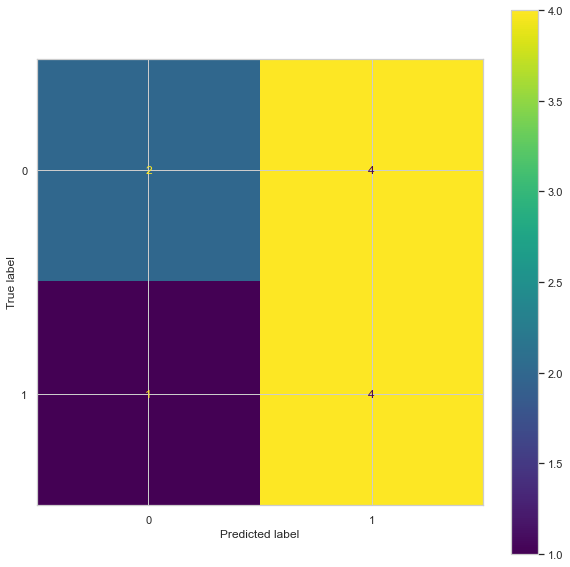

F-Score: 0.6153846153846154
Precision score: 0.5
Recall score: 0.8

------------

'open-close', 'low-high', 'Number of Likes' as features
SVC(kernel='poly', probability=True) : 
Training Accuracy :  0.2777777777777778
Validation Accuracy :  0.7666666666666667

Mean cross-validation score: 0.38
K-fold CV average score: 0.32
Confusion matrix output:


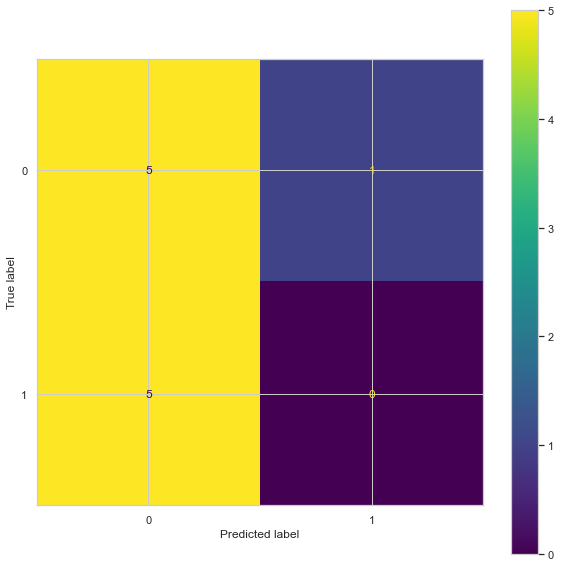

F-Score: 0.0
Precision score: 0.0
Recall score: 0.0

------------

'open-close', 'low-high', 'Number of Likes' as features
XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, ...) : 
Training Accuracy :  1.0
Validation Accuracy :  0.5666666666666667

Mean cross-validation score: 0.24
K-fold CV average score: 0.30
Confusion matrix output:


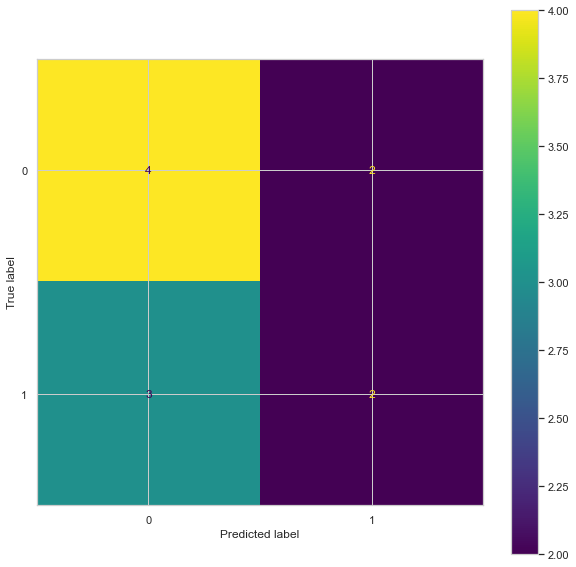

F-Score: 0.4444444444444445
Precision score: 0.5
Recall score: 0.4

------------



In [142]:
models = [LogisticRegression(), SVC(
    kernel='poly', probability=True), XGBClassifier()]
 
 
    
for i in range(3):
    print("'open-close', 'low-high', 'Number of Likes' as features") 
    models[i].fit(X_train, Y_train)

    print(f'{models[i]} : ')
    print('Training Accuracy : ', metrics.roc_auc_score(
        Y_train, models[i].predict_proba(X_train)[:,1]))
    print('Validation Accuracy : ', metrics.roc_auc_score(
        Y_valid, models[i].predict_proba(X_valid)[:,1]))
    print()

# --------------------------
    
    scores = cross_val_score(models[i], X_train, Y_train, cv=5)
    print("Mean cross-validation score: %.2f" % scores.mean())
    kfold = KFold(n_splits=10, shuffle=True)
    kf_cv_scores = cross_val_score(models[i], X_train, Y_train, cv=kfold )
    print("K-fold CV average score: %.2f" % kf_cv_scores.mean())

    ypred = models[i].predict(X_valid)
    cm = confusion_matrix(Y_valid,ypred)
    print("Confusion matrix output:")
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=clf.classes_) 
    disp.plot()
    plt.show()
    fscore = f1_score(Y_valid, ypred)
    print("F-Score:",fscore)
    precisionscore = precision_score(Y_valid, ypred)
    print("Precision score:", precisionscore)
    recallscore = recall_score(Y_valid, ypred)
    print("Recall score:", recallscore)
    print()
    print("------------")
    print()
# --------------------------

## PCA
### source: 01_PrincipalComponentAnalysis from class

'open-close', 'low-high', 'Number of Likes', 'Probs'

In [111]:
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA

merged_df_copy = merged_df[['open-close', 'low-high', 'Number of Likes', 'Probs']].copy()

In [112]:
merged_df_copy.head()

,open-close,low-high,Number of Likes,Probs
0,-0.000336,-0.000469,159553,0.985082
1,-0.000040,-0.000059,2275,0.990528
2,-0.016063,-0.021924,523602,-0.575867
3,-0.021280,-0.030118,57190,0.929430
4,-0.002785,-0.012566,517771,0.990182


In [113]:
X = pd.DataFrame(scale(merged_df_copy), index=merged_df_copy.index, columns=merged_df_copy.columns)

In [114]:
pca_loadings = pd.DataFrame(PCA().fit(X).components_.T, index=merged_df_copy.columns, columns=['open-close', 'low-high', 'Number of Likes', 'Probs'])
pca_loadings

,open-close,low-high,Number of Likes,Probs
open-close,-0.663410,0.077649,0.344347,0.659760
low-high,-0.671438,0.258690,-0.022045,-0.694092
Number of Likes,0.074875,0.816618,-0.515631,0.248301
Probs,-0.321639,-0.510084,-0.784260,0.145941


In [115]:
pca = PCA()
df_plot = pd.DataFrame(pca.fit_transform(X), columns=['PC1', 'PC2', 'PC3', 'PC4'], index=X.index)
df_plot.head()

,PC1,PC2,PC3,PC4
0,-0.992933,0.052401,-0.632178,-0.250701
1,-1.085262,-0.715711,-0.146329,-0.484705
2,0.791694,2.494892,-0.586098,0.062698
3,0.391961,-0.776167,-0.595111,-0.337543
4,-0.457171,1.679092,-1.775655,0.511260


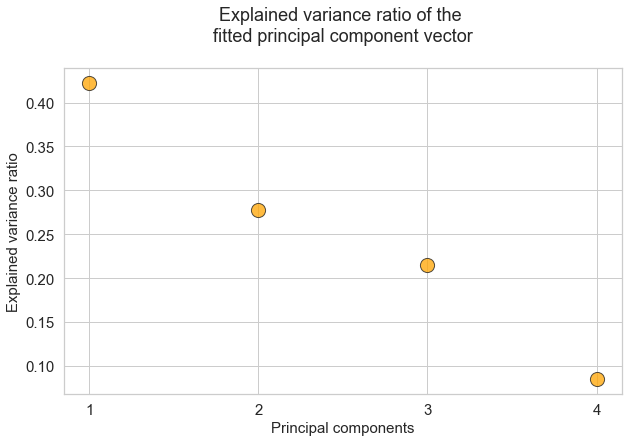

In [116]:
plt.figure(figsize=(10,6))
plt.scatter(x=[i+1 for i in range(len(pca.explained_variance_ratio_))],
            y=pca.explained_variance_ratio_,
           s=200, alpha=0.75,c='orange',edgecolor='k')
plt.grid(True)
plt.title("Explained variance ratio of the \nfitted principal component vector\n",fontsize=18)
plt.xlabel("Principal components",fontsize=15)
plt.xticks([i+1 for i in range(len(pca.explained_variance_ratio_))],fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("Explained variance ratio",fontsize=15)
plt.show()

([<matplotlib.axis.XTick at 0x2954cfd64c0>,
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

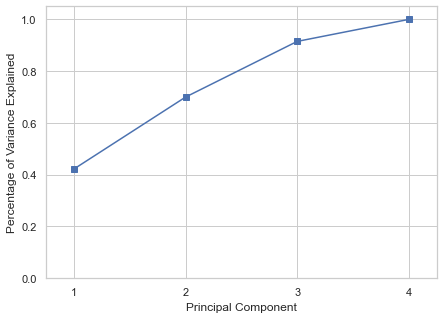

In [117]:
plt.figure(figsize=(7,5))
plt.plot([1,2,3,4], np.cumsum(pca.explained_variance_ratio_), '-s')
plt.ylabel('Percentage of Variance Explained')
plt.xlabel('Principal Component')
plt.xlim(0.75,4.25)
plt.ylim(0,1.05)
plt.xticks([1,2,3,4])



### PCA 3 features

'Number of Likes', 'Close', 'Probs'

In [118]:
from sklearn.preprocessing import scale
merged_df_copy = merged_df[['Number of Likes', 'Close', 'Probs']].copy()
X = pd.DataFrame(scale(merged_df_copy), index=merged_df_copy.index, columns=merged_df_copy.columns)
from sklearn.decomposition import PCA

pca_loadings = pd.DataFrame(PCA().fit(X).components_.T, index=merged_df_copy.columns, columns=['Number of Likes', 'Close', 'Probs'])
pca_loadings

,Number of Likes,Close,Probs
Number of Likes,-0.552269,0.607407,-0.571013
Close,0.768040,0.104333,-0.631846
Probs,-0.324212,-0.787510,-0.524133


In [119]:
pca = PCA()
df_plot = pd.DataFrame(pca.fit_transform(X), columns=['PC1', 'PC2', 'PC3'], index=X.index)
df_plot.head()

,PC1,PC2,PC3
0,-1.402049,-0.590991,0.320779
1,-0.887622,-1.169192,0.859268
2,-1.695644,2.204250,-0.243605
3,-0.553636,-0.846499,0.303017
4,-2.139095,0.769873,-1.279294


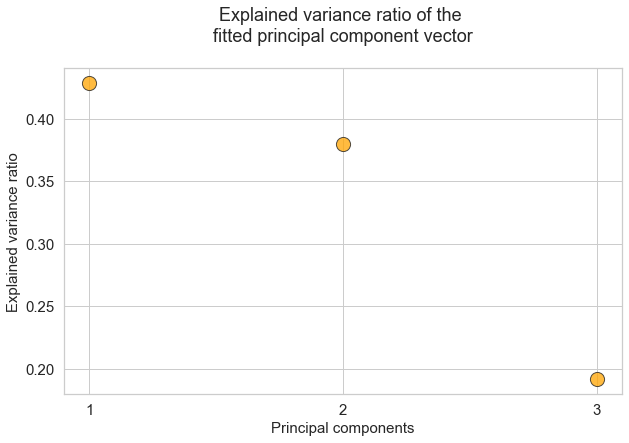

In [120]:
plt.figure(figsize=(10,6))
plt.scatter(x=[i+1 for i in range(len(pca.explained_variance_ratio_))],
            y=pca.explained_variance_ratio_,
           s=200, alpha=0.75,c='orange',edgecolor='k')
plt.grid(True)
plt.title("Explained variance ratio of the \nfitted principal component vector\n",fontsize=18)
plt.xlabel("Principal components",fontsize=15)
plt.xticks([i+1 for i in range(len(pca.explained_variance_ratio_))],fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("Explained variance ratio",fontsize=15)
plt.show()

([<matplotlib.axis.XTick at 0x2954d06c910>,
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

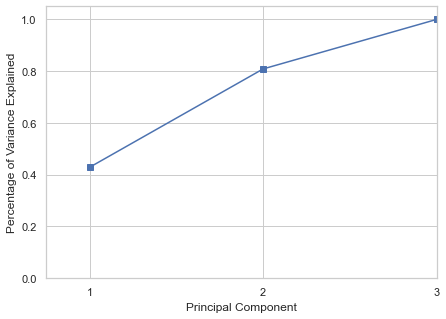

In [121]:
plt.figure(figsize=(7,5))
plt.plot([1,2,3], np.cumsum(pca.explained_variance_ratio_), '-s')
plt.ylabel('Percentage of Variance Explained')
plt.xlabel('Principal Component')
plt.xlim(0.75,3)
plt.ylim(0,1.05)
plt.xticks([1,2,3])



### PCA 3 features

'open-close', 'low-high', 'Probs'

In [122]:
from sklearn.preprocessing import scale
merged_df_copy = merged_df[['open-close', 'low-high', 'Probs']].copy()
X = pd.DataFrame(scale(merged_df_copy), index=merged_df_copy.index, columns=merged_df_copy.columns)
from sklearn.decomposition import PCA

pca_loadings = pd.DataFrame(PCA().fit(X).components_.T, index=merged_df_copy.columns, columns=['open-close', 'low-high', 'Probs'])
pca_loadings

,open-close,low-high,Probs
open-close,-0.662305,-0.290238,0.690734
low-high,-0.681855,-0.148605,-0.716233
Probs,-0.310525,0.945346,0.099478


In [123]:
pca = PCA()
df_plot = pd.DataFrame(pca.fit_transform(X), columns=['PC1', 'PC2', 'PC3'], index=X.index)
df_plot.head()

,PC1,PC2,PC3
0,-1.010695,0.500553,-0.353840
1,-1.032503,0.500079,-0.353924
2,0.597740,-0.870178,-0.504710
3,0.429590,0.898993,-0.293137
4,-0.631168,0.606790,-0.119255


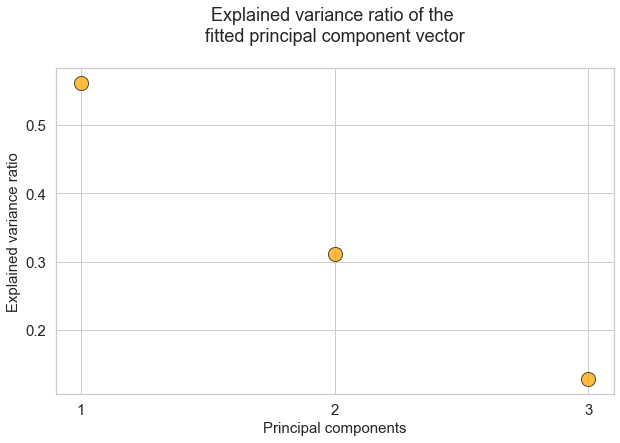

In [124]:
plt.figure(figsize=(10,6))
plt.scatter(x=[i+1 for i in range(len(pca.explained_variance_ratio_))],
            y=pca.explained_variance_ratio_,
           s=200, alpha=0.75,c='orange',edgecolor='k')
plt.grid(True)
plt.title("Explained variance ratio of the \nfitted principal component vector\n",fontsize=18)
plt.xlabel("Principal components",fontsize=15)
plt.xticks([i+1 for i in range(len(pca.explained_variance_ratio_))],fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("Explained variance ratio",fontsize=15)
plt.show()

([<matplotlib.axis.XTick at 0x2954d11efd0>,
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

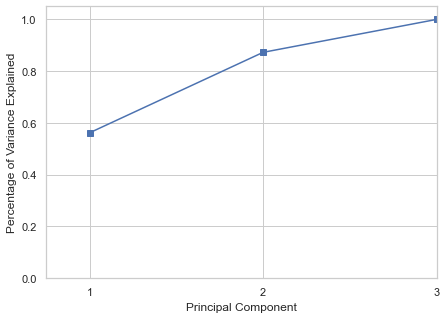

In [125]:
plt.figure(figsize=(7,5))
plt.plot([1,2,3], np.cumsum(pca.explained_variance_ratio_), '-s')
plt.ylabel('Percentage of Variance Explained')
plt.xlabel('Principal Component')
plt.xlim(0.75,3)
plt.ylim(0,1.05)
plt.xticks([1,2,3])



## PCA 6 features

'open-close', 'low-high', 'Number of Likes', 'Probs', 'Volume'

In [126]:
merged_df_copy = merged_df[['open-close', 'low-high', 'Probs', 'Number of Likes', 'Volume', 'Close']].copy()

In [127]:
merged_df_copy.head()

,open-close,low-high,Probs,Number of Likes,Volume,Close
0,-0.000336,-0.000469,0.985082,159553,6.029836e+07,0.002795
1,-0.000040,-0.000059,0.990528,2275,2.298104e+08,0.002142
2,-0.016063,-0.021924,-0.575867,523602,1.304084e+10,0.053289
3,-0.021280,-0.030118,0.929430,57190,1.426102e+10,0.078782
4,-0.002785,-0.012566,0.990182,517771,6.785088e+09,0.072896


In [128]:
X = pd.DataFrame(scale(merged_df_copy), index=merged_df_copy.index, columns=merged_df_copy.columns)

C:\Users\bjark\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(


In [129]:
pca_loadings = pd.DataFrame(PCA().fit(X).components_.T, index=merged_df_copy.columns, columns=['open-close', 'low-high', 'Probs', 'Number of Likes', 'Volume', 'Close'])
pca_loadings

,open-close,low-high,Probs,Number of Likes,Volume,Close
open-close,-0.459061,-0.211111,0.408627,-0.367190,-0.633739,0.203140
low-high,-0.564453,0.187189,0.098491,0.187625,0.053308,-0.773698
Probs,-0.240032,-0.195802,-0.862403,-0.370644,-0.128100,-0.080748
Number of Likes,0.018348,0.747829,0.071827,-0.638091,0.164282,0.033267
Volume,0.501730,0.288033,-0.124601,0.134579,-0.723294,-0.329412
Close,0.401212,-0.489737,0.242693,-0.517029,0.170238,-0.493950


In [130]:
pca = PCA()
df_plot = pd.DataFrame(pca.fit_transform(X), columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6'], index=X.index)
df_plot.head()

,PC1,PC2,PC3,PC4,PC5,PC6
0,-1.795004,0.521333,-0.642611,0.202820,0.248915,0.298075
1,-1.811427,-0.171210,-0.714587,0.807662,0.055461,0.247300
2,1.156455,3.183526,0.410307,-0.196185,-0.818313,-0.232772
3,1.200418,0.725754,-1.413618,0.906251,-1.523299,-0.485415
4,-0.434305,2.230171,-0.638002,-1.302088,-0.374326,-0.116449


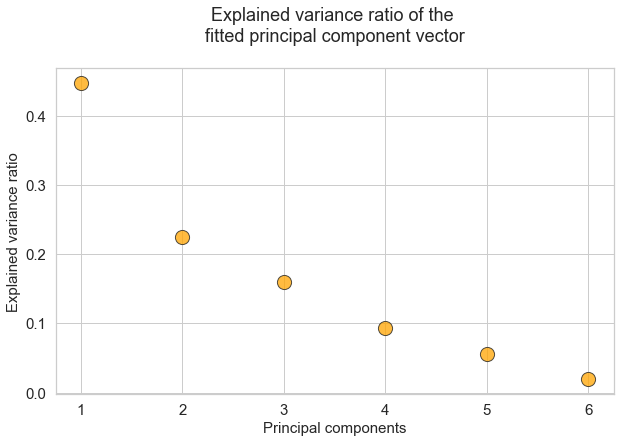

In [131]:
plt.figure(figsize=(10,6))
plt.scatter(x=[i+1 for i in range(len(pca.explained_variance_ratio_))],
            y=pca.explained_variance_ratio_,
           s=200, alpha=0.75,c='orange',edgecolor='k')
plt.grid(True)
plt.title("Explained variance ratio of the \nfitted principal component vector\n",fontsize=18)
plt.xlabel("Principal components",fontsize=15)
plt.xticks([i+1 for i in range(len(pca.explained_variance_ratio_))],fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("Explained variance ratio",fontsize=15)
plt.show()

([<matplotlib.axis.XTick at 0x2954d725040>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

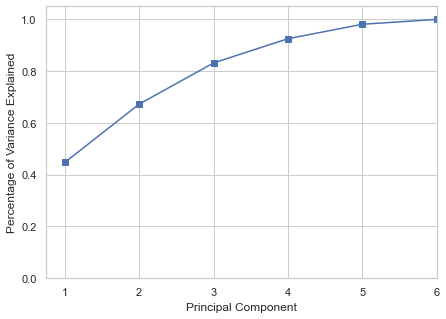

In [132]:
plt.figure(figsize=(7,5))
plt.plot([1,2,3,4,5,6], np.cumsum(pca.explained_variance_ratio_), '-s')
plt.ylabel('Percentage of Variance Explained')
plt.xlabel('Principal Component')
plt.xlim(0.75,6)
plt.ylim(0,1.05)
plt.xticks([1,2,3,4,5,6])



## 'open-close', 'low-high', 'Number of Likes', 'Probs', 'Volume' PCA

In [144]:
merged_df_copy = merged_df[['open-close', 'low-high', 'Number of Likes', 'Probs', 'Volume']].copy()
X = pd.DataFrame(scale(merged_df_copy), index=merged_df_copy.index, columns=merged_df_copy.columns)

C:\Users\bjark\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(


In [145]:
pca_loadings = pd.DataFrame(PCA().fit(X).components_.T, index=merged_df_copy.columns, columns=['open-close', 'low-high', 'Number of Likes', 'Probs', 'Volume'])
pca_loadings

,open-close,low-high,Number of Likes,Probs,Volume
open-close,-0.535706,0.140326,0.274397,0.786148,-0.002101
low-high,-0.544401,0.322070,-0.071013,-0.401915,0.658270
Number of Likes,0.120870,0.814673,-0.478063,0.103042,-0.287290
Probs,-0.257308,-0.457585,-0.827407,0.195248,0.041034
Volume,0.579508,0.059186,-0.080722,0.414362,0.694591


In [146]:
pca = PCA()
df_plot = pd.DataFrame(pca.fit_transform(X), columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'], index=X.index)
df_plot.head()

,PC1,PC2,PC3,PC4,PC5
0,-1.321782,0.109450,-0.643605,-0.340092,-0.104862
1,-1.430533,-0.652311,-0.198370,-0.414333,0.203394
2,1.992548,2.532664,-0.587953,0.487212,0.769208
3,1.669691,-0.659609,-0.767575,0.576453,1.643763
4,0.145091,1.788972,-1.802446,0.611792,0.070354


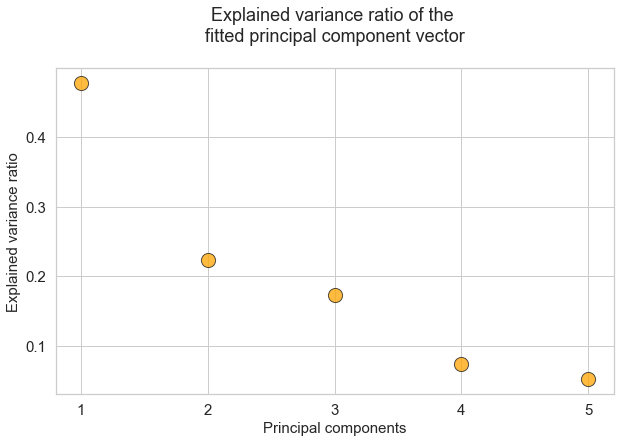

In [147]:
plt.figure(figsize=(10,6))
plt.scatter(x=[i+1 for i in range(len(pca.explained_variance_ratio_))],
            y=pca.explained_variance_ratio_,
           s=200, alpha=0.75,c='orange',edgecolor='k')
plt.grid(True)
plt.title("Explained variance ratio of the \nfitted principal component vector\n",fontsize=18)
plt.xlabel("Principal components",fontsize=15)
plt.xticks([i+1 for i in range(len(pca.explained_variance_ratio_))],fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("Explained variance ratio",fontsize=15)
plt.show()

([<matplotlib.axis.XTick at 0x2954e4b31c0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

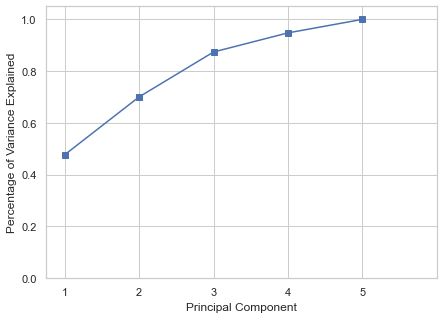

In [149]:
plt.figure(figsize=(7,5))
plt.plot([1,2,3,4,5], np.cumsum(pca.explained_variance_ratio_), '-s')
plt.ylabel('Percentage of Variance Explained')
plt.xlabel('Principal Component')
plt.xlim(0.75,6)
plt.ylim(0,1.05)
plt.xticks([1,2,3,4,5])

